# Descripción
   ### Los datos están relacionados con campañas de marketing directo de una institución bancaria. Las campañas de marketing se basaron en llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente, para poder acceder si el producto (depósito a plazo bancario) estaría ('sí') o no ('no') suscrito.


    Reglas y método de evaluación
    
    El desafío consistirá en que cada grupo formado deberá entregar un arreglo con los resultados ('yes' o 'no') y se medirá la medida de desempeño F1 score (macro).
    
    EL archivo de entrega debe ser en formato csv sin indice. Debe ser una sola columna con valores ´yes´ o ´no´ en 5210 filas


#### Variables de entrada:

# datos del cliente bancario:
1 - edad (numérico)

2 - trabajo: tipo de trabajo (categórico: 'admin.', 'Obrero', 'emprendedor', 'empleada doméstica', 'gerencia', 'jubilado', 'autónomo', 'servicios', 'estudiante' , 'técnico', 'desempleado', 'desconocido')

3 - marital: estado civil (categórico: 'divorciado', 'casado', 'soltero', 'desconocido'; nota: 'divorciado' significa divorciado o viudo)

4 - educación (categórica: 'básico.4y', 'básico.6y', 'básico.9y', 'escuela secundaria', 'analfabeto', 'curso.profesional', 'título universitario', 'desconocido')

5 - incumplimiento: ¿tiene crédito en incumplimiento? (categórico: 'no', 'sí', 'desconocido')

6 - vivienda: ¿tiene préstamo para vivienda? (categórico: 'no', 'sí', 'desconocido')

7 - préstamo: ¿tiene préstamo personal? (categórico: 'no', 'sí', 'desconocido')

# relacionado con el último contacto de la campaña actual:

8 - contacto: tipo de comunicación de contacto (categórico: 'celular', 'teléfono')

9 - mes: último mes de contacto del año (categórico: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: último día de contacto de la semana (categórico: 'lun', 'tue', 'mié', 'jue', 'vie')

11 - duración: duración del último contacto, en segundos (numérico). Nota importante: este atributo afecta en gran medida el objetivo de salida (por ejemplo, si duración = 0, entonces y = 'no'). Sin embargo, se desconoce la duración antes de realizar una llamada. Además, después de la finalización de la llamada y, obviamente, se conoce. Por lo tanto, esta entrada solo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista.

# otros atributos:

12 - campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye último contacto)

13 - pdays: número de días que pasaron después de que el cliente fue contactado por última vez desde una campaña anterior (numérico; 999 significa que el cliente no fue contactado previamente)

14 - anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)

15 - poutcome: resultado de la campaña de marketing anterior (categórico: 'fracaso', 'inexistente', 'éxito')

Variable de salida (objetivo deseado):

21 - y - ¿el cliente ha suscrito un depósito a plazo? (binario: 'sí', 'no')


# Comenzando

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


from imblearn.over_sampling import RandomOverSampler
import imblearn

In [2]:
df_train = pd.read_csv('Trainset.csv', index_col= 'Unnamed: 0')
df_test = pd.read_csv('TestFeatures.csv')
final = pd.read_csv('submission_example.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  pdays      40000 non-null  int64 
 14  previous   40000 non-null  int64 
 15  poutcome   40000 non-null  object
 16  y          40000 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.5+ MB


In [4]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,46,management,single,tertiary,no,593,yes,no,cellular,29,jan,190,3,-1,0,unknown,no
1,42,admin.,married,tertiary,no,1536,no,no,cellular,6,aug,140,1,182,4,failure,no
2,33,blue-collar,married,secondary,no,370,yes,no,cellular,8,apr,249,1,-1,0,unknown,no
3,29,blue-collar,single,secondary,no,1472,no,no,cellular,18,may,246,2,-1,0,unknown,no
4,29,technician,married,secondary,no,767,yes,no,cellular,5,feb,253,1,-1,0,unknown,no


## Eliminar Columnas
duration   



In [5]:
df_train = df_train.drop(['duration'], axis=1)

## Distribution

In [6]:
df_train['job'].value_counts()/df_train['poutcome'].shape[0]

blue-collar      0.214075
management       0.209575
technician       0.169400
admin.           0.115025
services         0.091850
retired          0.049625
self-employed    0.034675
entrepreneur     0.033150
unemployed       0.028200
housemaid        0.027200
student          0.020775
unknown          0.006450
Name: job, dtype: float64

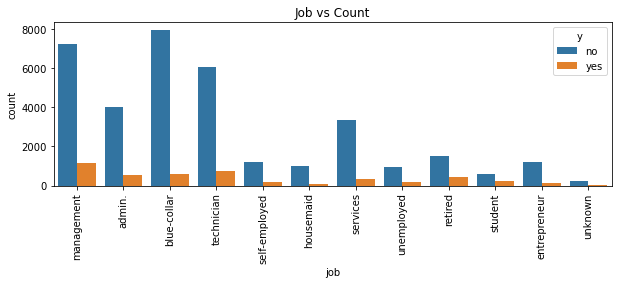

In [7]:
plt.figure(figsize = (10,3))
sns.countplot(x="job", data = df_train, hue ="y")
plt.title("Job vs Count")
plt.xticks(rotation=90)
plt.show()

### Mayormente los usuarios NO tiene contratado el producto

In [8]:
# df_train.hist(figsize=(12,12), color = 'darkblue')
# plt.show()

In [9]:
df_train['day'].sort_values(ascending= True).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

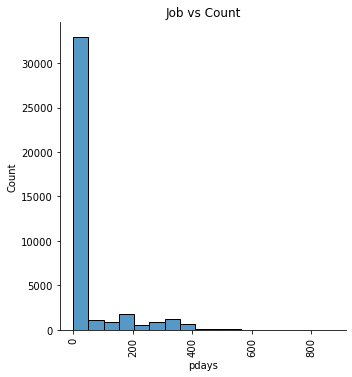

-1      32715
 182      138
 92       128
 183      113
 91       108
 181      103
 370       86
 184       74
 364       71
 350       67
Name: pdays, dtype: int64


In [10]:
sns.displot(x="pdays", data = df_train)
plt.title("Job vs Count")
plt.xticks(rotation=90)
plt.show()
print(df_train.pdays.value_counts().sort_values(ascending= False).head(10))

###### Aparentemente gran parte de los clientes fueron por eso haremos una transformacion a los valores -1 a 999.

In [11]:
# remplazamos el valor -1 por 999
df_train.loc[(df_train.pdays == -1),"pdays"] = 999

In [12]:
df_train.y.value_counts()

no     35347
yes     4653
Name: y, dtype: int64

In [13]:
df_train.job.value_counts()

blue-collar      8563
management       8383
technician       6776
admin.           4601
services         3674
retired          1985
self-employed    1387
entrepreneur     1326
unemployed       1128
housemaid        1088
student           831
unknown           258
Name: job, dtype: int64

In [14]:
df_train.contact.value_counts()

cellular     25915
unknown      11528
telephone     2557
Name: contact, dtype: int64

In [15]:
df_train.y.value_counts()/df_train.shape[0]

no     0.883675
yes    0.116325
Name: y, dtype: float64

###### Poutcome es una variable con muchos datos faltantes por que la quitaremos

In [16]:
df_train.poutcome.value_counts()

unknown    32720
failure     4350
other       1610
success     1320
Name: poutcome, dtype: int64

In [17]:
df_train.drop('poutcome', axis = 1, inplace = True)

In [18]:
df_train.contact.value_counts()

cellular     25915
unknown      11528
telephone     2557
Name: contact, dtype: int64

    Aca es necesario imputar algunos valores.

In [19]:
df_train.marital.value_counts()

married     24017
single      11364
divorced     4619
Name: marital, dtype: int64

In [20]:
df_train['campaign'].sort_values(ascending= True).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 41, 43, 44, 46, 50, 51, 55, 58, 63],
      dtype=int64)

### Relacion entre la edad y producto (depósito a plazo bancario) 

C:\Users\leogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\leogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\leogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

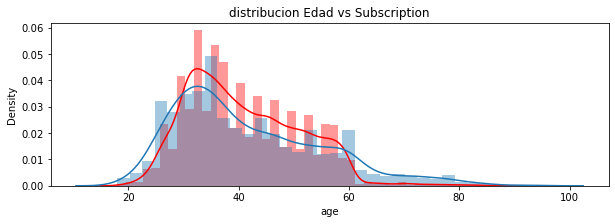

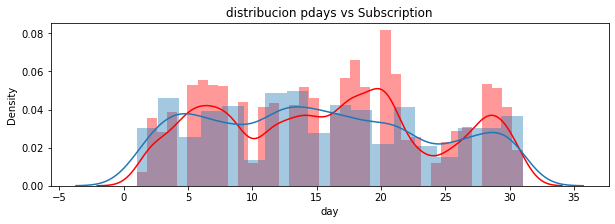

In [21]:
plt.figure(figsize = (10,3))
sns.distplot(df_train.loc[df_train.y == 'no', 'age'], label = "no", hist = True, color='red')
sns.distplot(df_train.loc[df_train.y == 'yes', 'age'], label = "yes", hist = True)
plt.title("distribucion Edad vs Subscription")

plt.figure(figsize = (10,3))
sns.distplot(df_train.loc[df_train.y == 'no', 'day'], label = "no", hist = True, color='red')
sns.distplot(df_train.loc[df_train.y == 'yes', 'day'], label = "yes", hist = True)
plt.title("distribucion pdays vs Subscription")
plt.show()


    Podemos observar que las personas entre 20 y 60 años son mas propicios a contratar el producto con un pic cerca a los 30 años donde, asi mismo podemos observar que los clientes aceptan el producto con mayor proporcion antes de los 15 primeros dias del mes, reduciendo en la medida que concluye el mes.

Text(0.5, 1.0, 'Age Distribution by Job, Divided by Subscription (0) for Not Subscribed, (1) for Subscribed')

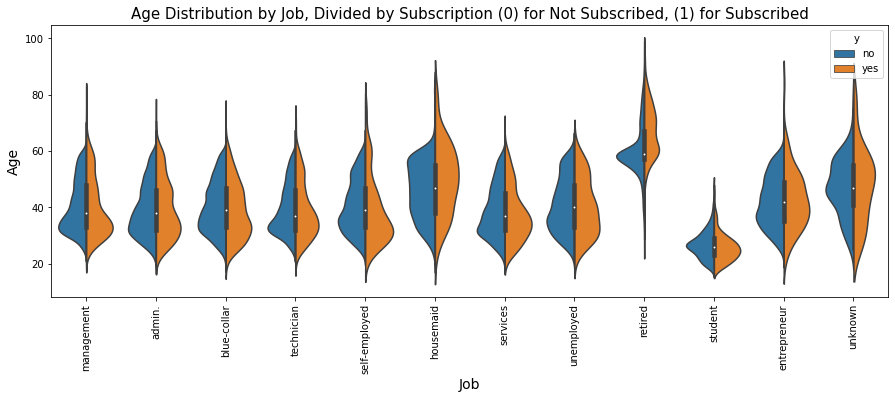

In [22]:
plt.figure( figsize = (15, 5))
sns.violinplot(x = 'job', y = 'age', hue = 'y', data = df_train, split = True)
plt.xlabel("Job", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.xticks(rotation=90)
plt.title("Age Distribution by Job, Divided by Subscription (0) for Not Subscribed, (1) for Subscribed", fontsize = 15)

Es relevante mencionar que las personas entre 30 y 50 años son mas propicios a contratar el productos sobre todo en aquellos que se han retirado. Esto puede estar relacionados a las expectativas relacionadas con la mayoria de edad y cercania con la jubilacion. Tambien es interesante la relacion con las dueñas de casa, quienes tienden a tomar el productos cuando se acercan a los 40 años.

# Preproceso de datos Ecoding Test Train

### Copias de los datos.

In [23]:
# Datos sin balanceo
df_prep = df_train.copy()
df_train_oh = df_train.copy()

# Valores ausentes o no registrados

### Educacion vs Trabajo

        Suponemos que para cierto nivel de trabajo calificado es necesario un grado mayor de educacion, por tanto podemos inferir el nivel educacion en funcion del tipo de trabajo que realiza.

In [24]:
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "admin."),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "management"),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "services"),"education"] = "tertiary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "technician."),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "retired"),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "blue-collar"),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "housemaid."),"education"] = "primary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "self-employed"),"education"] = "tertiary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "student"),"education"] = "secondary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "entrepreneur"),"education"] = "tertiary"
df_train_oh.loc[(df_train_oh.education == "unknown") & (df_train_oh.job == "unemployed"),"education"] = "secondary"
#REST CAN BE SECONDARY
df_train_oh.loc[(df_train_oh.education == "unknown"),"education"] = "secondary"

In [25]:
df_train_oh['education'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

#### Contacto  y Trabajo seran remplazados por la moda en el caso de los ausentes

In [26]:
df_train_oh["contact"].replace(["unknown"],df_train_oh["contact"].mode(),inplace = True) 
df_train_oh["job"].replace(["unknown"],df_train_oh["job"].mode(),inplace = True) 

In [27]:
df_train_oh['job'].unique(), df_train_oh['contact'].unique()

(array(['management', 'admin.', 'blue-collar', 'technician',
        'self-employed', 'housemaid', 'services', 'unemployed', 'retired',
        'student', 'entrepreneur'], dtype=object),
 array(['cellular', 'telephone'], dtype=object))

# Encoding de datos Train

### Categorizacion y Dummies

In [28]:
df_train_oh.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,y
0,46,management,single,tertiary,no,593,yes,no,cellular,29,jan,3,999,0,no
1,42,admin.,married,tertiary,no,1536,no,no,cellular,6,aug,1,182,4,no
2,33,blue-collar,married,secondary,no,370,yes,no,cellular,8,apr,1,999,0,no
3,29,blue-collar,single,secondary,no,1472,no,no,cellular,18,may,2,999,0,no
4,29,technician,married,secondary,no,767,yes,no,cellular,5,feb,1,999,0,no


In [29]:
# Clasificaion de bariables categoricas
df_train_oh['education'].replace(['tertiary', 'secondary', 'primary'],[2,1,0],inplace=True)
df_train_oh['contact'].replace(['cellular','telephone'],[1,0],inplace=True) #las personas poco usar el telefono fijo
df_train_oh['default'].replace(['yes','no'],[1,0],inplace=True)
df_train_oh['housing'].replace(['yes','no'],[1,0],inplace=True)
df_train_oh['loan'].replace(['yes','no'],[1,0],inplace=True)
df_train_oh['y'].replace(['yes','no'],[1,0],inplace=True)
df_train_oh['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug' , 'sep','oct','nov','dec'],
                         [1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)

#CATEGORICAS ['job','marital','education','contact','month','poutcome']
#NUMERICAS ['age','balance','day','campaign','pdays','previous']
#BINARIAS  ['default','housing','loan','y']  

In [30]:
df_train_oh = df_dummies = pd.get_dummies(df_train_oh,columns = ['job','marital'],
               drop_first = True)

In [31]:
df_train_oh.head()

,age,education,default,balance,housing,loan,contact,day,month,campaign,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
0,46,2,0,593,1,0,1,29,1,3,...,0,1,0,0,0,0,0,0,0,1
1,42,2,0,1536,0,0,1,6,8,1,...,0,0,0,0,0,0,0,0,1,0
2,33,1,0,370,1,0,1,8,4,1,...,0,0,0,0,0,0,0,0,1,0
3,29,1,0,1472,0,0,1,18,5,2,...,0,0,0,0,0,0,0,0,0,1
4,29,1,0,767,1,0,1,5,2,1,...,0,0,0,0,0,0,1,0,1,0


### Dias meses o pdays

    En relacion a las variables de tiempo, podriamos elimar el mes y el dia considerando que tenemos la variables pdays que mide el tiempo del ultimo contacto, sin embargo esto no seria propicio considerando mayormente los valores de pdays son sin contacto previo.

C:\Users\leogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\leogo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


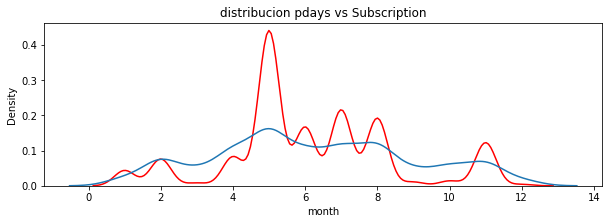

In [32]:
plt.figure(figsize = (10,3))
sns.distplot(df_train_oh.loc[df_train_oh.y == 0, 'month'], label = 0, hist = False, color='red')
sns.distplot(df_train_oh.loc[df_train_oh.y == 1, 'month'], label = 1, hist = False)
plt.title("distribucion pdays vs Subscription")
plt.show()

    Ademas los clientes tiene un compartemineto mas normal en la contratcion del producto que aquellos que no lo tiene. Es decir inicion y fines de año no parecen ser momentos propicios de contratacion.

## Normalizacion Manual Train

In [33]:
# #selecionamos las columnas que normalizaremos
df_norm = df_train_oh[['age','balance','campaign','pdays','previous']]
df_prep2 = df_train_oh.drop(columns=['age','balance','campaign','pdays','previous'])

from sklearn.preprocessing import MinMaxScaler
df_trans = MinMaxScaler()
df_trans = df_trans.fit_transform(df_norm)

df_trans = pd.DataFrame(df_trans)
df_trans.columns = df_norm.columns

df_train_trans = pd.concat([df_trans, df_prep2], axis=1,)
df_train_trans.reindex(columns=['age','job','marital','education','default','balance','housing',
                          'loan','contact','day','month','campaign','pdays','previous','y'])

df_train_trans.head()

,age,balance,campaign,pdays,previous,education,default,housing,loan,contact,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
0,0.363636,0.078187,0.032258,1.000000,0.000000,2,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0.311688,0.086748,0.000000,0.181363,0.014545,2,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.194805,0.076163,0.000000,1.000000,0.000000,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.142857,0.086167,0.016129,1.000000,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0.142857,0.079767,0.000000,1.000000,0.000000,1,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0


In [34]:
df_train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                40000 non-null  float64
 1   balance            40000 non-null  float64
 2   campaign           40000 non-null  float64
 3   pdays              40000 non-null  float64
 4   previous           40000 non-null  float64
 5   education          40000 non-null  int64  
 6   default            40000 non-null  int64  
 7   housing            40000 non-null  int64  
 8   loan               40000 non-null  int64  
 9   contact            40000 non-null  int64  
 10  day                40000 non-null  int64  
 11  month              40000 non-null  int64  
 12  y                  40000 non-null  int64  
 13  job_blue-collar    40000 non-null  uint8  
 14  job_entrepreneur   40000 non-null  uint8  
 15  job_housemaid      40000 non-null  uint8  
 16  job_management     400

# Preproceso datos test

#### Esto es necesario para poder probar el modelo sobre la misma estructura de datos pre_procesados de train.

In [35]:
df_test = df_test.drop(['duration','poutcome'], axis=1)

In [36]:
df_test.loc[(df_test.education == "unknown") & (df_test.job == "admin."),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "management"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "services"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "technician."),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "retired"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "blue-collar"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "housemaid."),"education"] = "primary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "self-employed"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "student"),"education"] = "secondary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "entrepreneur"),"education"] = "tertiary"
df_test.loc[(df_test.education == "unknown") & (df_test.job == "unemployed"),"education"] = "secondary"
#REST CAN BE SECONDARY
df_test.loc[(df_test.education == "unknown"),"education"] = "secondary"

In [37]:
df_test['education'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

#### Contacto  y Trabajo seran remplazados por la moda en el caso de los ausentes

In [38]:
df_test["contact"].replace(["unknown"],df_test["contact"].mode(),inplace = True) 
df_test["job"].replace(["unknown"],df_test["job"].mode(),inplace = True) 

In [39]:
df_test['job'].unique(), df_test['contact'].unique()

(array(['admin.', 'retired', 'entrepreneur', 'management', 'technician',
        'self-employed', 'blue-collar', 'services', 'unemployed',
        'student', 'housemaid'], dtype=object),
 array(['telephone', 'cellular'], dtype=object))

In [40]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous
0,51,admin.,single,tertiary,no,394,no,no,telephone,28,jan,2,-1,0
1,56,retired,married,secondary,no,334,no,no,cellular,21,jul,1,-1,0
2,50,entrepreneur,married,tertiary,no,52,no,no,cellular,31,jul,8,-1,0
3,54,entrepreneur,married,secondary,no,653,yes,no,cellular,15,may,1,-1,0
4,47,management,married,tertiary,no,0,no,no,cellular,19,aug,2,-1,0


In [41]:
# Clasificaion de bariables categoricas
df_test['education'].replace(['tertiary', 'secondary', 'primary'],[2,1,0],inplace=True)
df_test['contact'].replace(['cellular','telephone'],[1,0],inplace=True) #las personas poco usar el telefono fijo
df_test['default'].replace(['yes','no'],[1,0],inplace=True)
df_test['housing'].replace(['yes','no'],[1,0],inplace=True)
df_test['loan'].replace(['yes','no'],[1,0],inplace=True)
df_test['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug' , 'sep','oct','nov','dec'],
                         [1,2,3,4,5,6,7,8,9,10,11,12],inplace=True)

#CATEGORICAS ['job','marital','education','contact','month','poutcome']
#NUMERICAS ['age','balance','day','campaign','pdays','previous']
#BINARIAS  ['default','housing','loan','y']  

In [42]:
df_test = df_dummies = pd.get_dummies(df_test,columns = ['job','marital'],
               drop_first = True)

In [43]:
df_test.head()

,age,education,default,balance,housing,loan,contact,day,month,campaign,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
0,51,2,0,394,0,0,0,28,1,2,...,0,0,0,0,0,0,0,0,0,1
1,56,1,0,334,0,0,1,21,7,1,...,0,0,1,0,0,0,0,0,1,0
2,50,2,0,52,0,0,1,31,7,8,...,0,0,0,0,0,0,0,0,1,0
3,54,1,0,653,1,0,1,15,5,1,...,0,0,0,0,0,0,0,0,1,0
4,47,2,0,0,0,0,1,19,8,2,...,0,1,0,0,0,0,0,0,1,0


## Normalizacion Test

In [44]:
# #selecionamos las columnas que normalizaremos
df_norm = df_test[['age','balance','campaign','pdays','previous']]
df_prep2 = df_test.drop(columns=['age','balance','campaign','pdays','previous'])

from sklearn.preprocessing import MinMaxScaler
df_tes_trans = MinMaxScaler()
df_tes_trans = df_tes_trans.fit_transform(df_norm)

df_tes_trans = pd.DataFrame(df_tes_trans)
df_tes_trans.columns = df_norm.columns

df_test_trans = pd.concat([df_tes_trans, df_prep2], axis=1,)
df_test_trans.reindex(columns=['age','job','marital','education','default','balance','housing',
                          'loan','contact','day','month','campaign','pdays','previous','y'])

df_test_trans.head()

,age,balance,campaign,pdays,previous,education,default,housing,loan,contact,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single
0,0.470588,0.073101,0.023810,0.0,0.0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.544118,0.072116,0.000000,0.0,0.0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0.455882,0.067485,0.166667,0.0,0.0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.514706,0.077355,0.000000,0.0,0.0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.411765,0.066631,0.023810,0.0,0.0,2,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


# Balanceo de datos

# Oversampling

In [45]:
#Separamos el set de datos
x = df_train_trans.drop(['y'], axis=1)
y = df_train_trans['y']

In [46]:
random_over = RandomOverSampler(sampling_strategy= 0.6,
                               random_state=123)

X_over,y_over = random_over.fit_resample(x,y)
df_over = X_over
df_over['y'] = y_over

print(df_over.y.value_counts()/df_over.shape[0])
print(df_over.y.value_counts())
print(df_over.shape)
df_over.head()

0    0.625002
1    0.374998
Name: y, dtype: float64
0    35347
1    21208
Name: y, dtype: int64
(56555, 25)


,age,balance,campaign,pdays,previous,education,default,housing,loan,contact,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,y
0,0.363636,0.078187,0.032258,1.000000,0.000000,2,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0.311688,0.086748,0.000000,0.181363,0.014545,2,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.194805,0.076163,0.000000,1.000000,0.000000,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.142857,0.086167,0.016129,1.000000,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.142857,0.079767,0.000000,1.000000,0.000000,1,0,1,0,1,...,0,0,0,0,0,1,0,1,0,0


# Multicolinealidad

    ocurre cuando una variable independiente en un modelo de regresión se correlaciona linealmente con otra variable independiente.
    
Los coeficientes de regresión ajustados (beta hat) cambiarán sustancialmente si uno de los valores de una de las x variables se cambia solo un poco.

La varianza de los coeficientes estimados se inflará, lo que significa que será difícil detectar la significación estadística. Además, es posible que el estadístico F sea significativo pero los estadísticos t individuales no lo sean.

En última instancia, la multicolinealidad hace que la predicción sea menos precisa. Para un modelo dado, el supuesto subyacente es que las relaciones entre las variables predictoras, así como su relación con la variable objetivo, serán las mismas. Sin embargo, cuando existe multicolinealidad, es menos probable que sea el caso.


Donde  R2  se obtiene de la regresión del predictor  Xj  sobre los otros predictores. Esta es la opción más recomendada, los límites de referencia que se suelen emplear son:

VIF = 1: ausencia total de colinealidad

1 < VIF < 5: la regresión puede verse afectada por cierta colinealidad.

5 < VIF < 10: la regresión puede verse altamente afectada por cierta colinealidad.

El término tolerancia es  1VIF  por lo que los límites recomendables están entre 1 y 0.1.

In [ ]:
# df_train.columns

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# X_variables = df [['age', 'job', 'marital', 
#                    'education','default', 'balance', 
#                    'housing','loan', 'contact', 'day', 
#                    'month', 'campaign', 'pdays', 'previous',
#                    'poutcome', 'y']]
# vif_data = pd.DataFrame () 
# vif_data ["feature"] = X_variables.columns 
# vif_data ["VIF"] = [varnce_inflation_factor (X_variables.values, i) for i in range (len (X_variables.columns))]

In [ ]:
# correlation_matrix = df_train.corr()
# sns.heatmap(correlation_matrix, annot =True)

In [ ]:
# print(df_train.corr())

# Ejecutando Modelos 

In [ ]:
#df_train_trans
#df_over
#df_under
#df_train_oh

In [ ]:
#df_over = df_over.sample(frac=0.95, random_state=786)

In [73]:
from pycaret.classification import *
clf1 = setup(data = df_over,
             target = 'y',
             train_size=0.8,
             session_id=123,
            )

best_model = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9626,0.9912,0.9761,0.9279,0.9514,0.9210,0.9218,3.4750
rf,Random Forest Classifier,0.9591,0.9905,0.9786,0.9178,0.9472,0.9139,0.9152,2.8440
dt,Decision Tree Classifier,0.9139,0.9268,0.9779,0.8249,0.8949,0.8229,0.8315,0.2210
knn,K Neighbors Classifier,0.8030,0.8885,0.8275,0.7007,0.7588,0.5942,0.6001,1.5440
xgboost,Extreme Gradient Boosting,0.8127,0.8835,0.6381,0.8220,0.7184,0.5814,0.5919,3.7560
catboost,CatBoost Classifier,0.8023,0.8732,0.6076,0.8177,0.6971,0.5551,0.5686,9.6300
lightgbm,Light Gradient Boosting Machine,0.7805,0.8441,0.5599,0.7932,0.6564,0.5021,0.5185,0.5910
gbc,Gradient Boosting Classifier,0.7561,0.7814,0.4906,0.7758,0.6010,0.4379,0.4618,3.4130
ada,Ada Boost Classifier,0.7380,0.7555,0.4600,0.7424,0.5680,0.3945,0.4179,0.8020
lr,Logistic Regression,0.7255,0.7371,0.4433,0.7156,0.5474,0.3656,0.3873,1.7570


    Precision nos da la calidad de la predicción: ¿qué porcentaje de los que hemos dicho que son la clase positiva, en realidad lo son?
    
    Recall nos da la cantidad: ¿qué porcentaje de la clase positiva hemos sido capaces de identificar?
    
    F1 combina Precision y Recall en una sola medida
    
    La Matriz de Confusión indica qué tipos de errores se cometen

In [48]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9573,0.9868,0.9704,0.9202,0.9446,0.9099,0.9108
1,0.9515,0.9828,0.9596,0.9152,0.9369,0.8975,0.8982
2,0.9560,0.9870,0.9684,0.9188,0.9430,0.9072,0.9081
3,0.9515,0.9877,0.9717,0.9058,0.9376,0.8980,0.8995
4,0.9500,0.9841,0.9650,0.9075,0.9354,0.8947,0.8958
5,0.9545,0.9879,0.9771,0.9086,0.9416,0.9045,0.9061
6,0.9419,0.9821,0.9630,0.8910,0.9256,0.8780,0.8798
7,0.9452,0.9826,0.9637,0.8978,0.9296,0.8848,0.8863
8,0.9452,0.9807,0.9522,0.9064,0.9287,0.8842,0.8849
9,0.9480,0.9840,0.9657,0.9025,0.9330,0.8905,0.8919


In [66]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


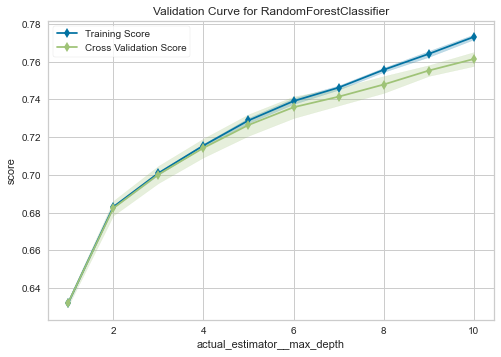

In [51]:
plot_model(estimator = rf, plot = 'vc') #revisar

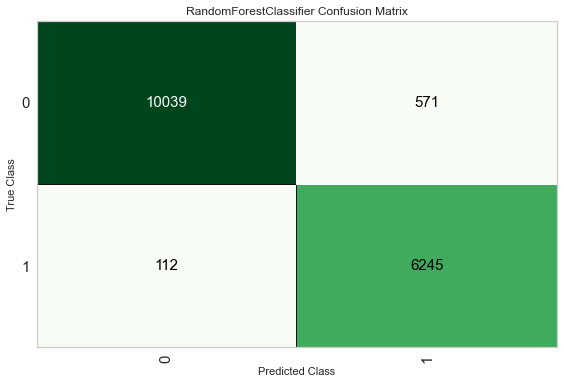

In [52]:
plot_model(rf, plot = 'confusion_matrix')

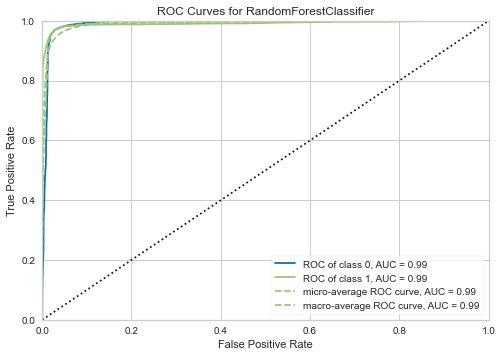

In [53]:
plot_model(rf, plot = 'auc')

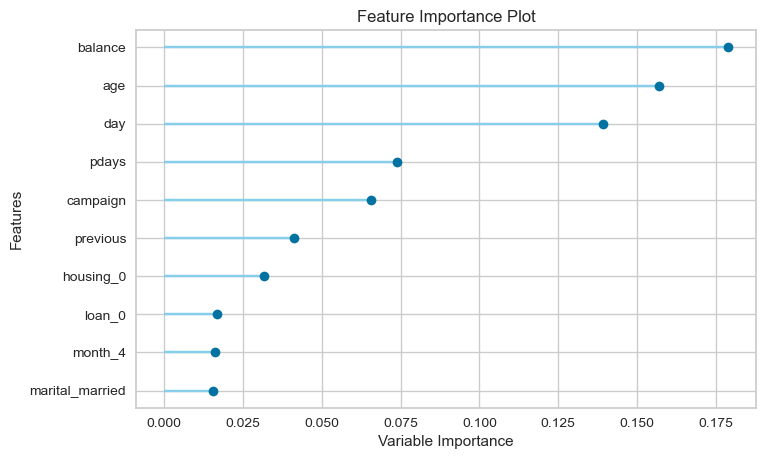

In [49]:
plot_model(rf, plot = 'feature')

In [ ]:
#evaluate_model(rf)

## Auto_Mod

In [ ]:
# auto_mod = setup(data = df_over,  target = 'y')

# top3 = compare_models(n_select = 2)
# tuned_top3 = [tune_model(i) for i in top3]
# blender = blend_models(tuned_top3)
# stacker = stack_models(tuned_top3)
# best_f1_model = automl(optimize = 'F1')

# Optimizando Hiperparametros
### por F1

In [65]:
tuned_rf = tune_model(rf,optimize ='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7229,0.7486,0.5960,0.6404,0.6174,0.4006,0.4013
1,0.7252,0.7408,0.5603,0.6567,0.6047,0.3961,0.3990
2,0.7272,0.7529,0.5697,0.6573,0.6104,0.4022,0.4046
3,0.7247,0.7494,0.5805,0.6486,0.6127,0.4001,0.4016
4,0.7275,0.7446,0.5811,0.6538,0.6153,0.4054,0.4071
5,0.7270,0.7460,0.5811,0.6528,0.6149,0.4045,0.4061
6,0.7110,0.7312,0.5697,0.6262,0.5966,0.3723,0.3733
7,0.7168,0.7376,0.5619,0.6398,0.5984,0.3811,0.3830
8,0.7244,0.7413,0.5717,0.6511,0.6088,0.3974,0.3994
9,0.7170,0.7380,0.5684,0.6379,0.6011,0.3830,0.3845


Optimizacion empeora el modelo con hiperparametros por defecto

In [ ]:
print(tuned_rf)

# Prediccion

In [54]:
predict_model(rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9597,0.9909,0.9824,0.9162,0.9482,0.9153,0.9168


In [55]:
rf_final = finalize_model(rf)
#Parámetros finales del modelo Random Forest para su despliegue a producción
print(rf_final)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


    Al utilizar pycaret no es recomendable utilizar el predict luego de finalizar, dado que estariamos intentando predecir los mismo datos que entrenamos.

# Testeando resultados.

In [56]:
test_predictions = predict_model(rf_final, data = df_test_trans)
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5210 non-null   float64
 1   balance            5210 non-null   float64
 2   campaign           5210 non-null   float64
 3   pdays              5210 non-null   float64
 4   previous           5210 non-null   float64
 5   education          5210 non-null   int64  
 6   default            5210 non-null   int64  
 7   housing            5210 non-null   int64  
 8   loan               5210 non-null   int64  
 9   contact            5210 non-null   int64  
 10  day                5210 non-null   int64  
 11  month              5210 non-null   int64  
 12  job_blue-collar    5210 non-null   uint8  
 13  job_entrepreneur   5210 non-null   uint8  
 14  job_housemaid      5210 non-null   uint8  
 15  job_management     5210 non-null   uint8  
 16  job_retired        5210 

# Resultado

In [57]:
from pycaret.utils import check_metric
check_metric(test_predictions['default'], test_predictions['Label'], metric = 'Accuracy')

0.9478

In [68]:
check_metric(test_predictions['default'], test_predictions['Label'], metric = 'F1')

0.0

In [77]:
check_metric(test_predictions.default, test_predictions.Label, metric = 'Recall')

0.0

In [74]:
print("Confidence Score :   {}".format(round(test_predictions.Score.mean(),2)))#Confidence Score

Confidence Score :   0.79


# Guardando datos para carga

In [ ]:
test_predictions['Label'].replace([1,0],['yes','no'],inplace=True)

In [ ]:
label = test_predictions[['Label']]

In [ ]:
label.to_csv('example_bagged.csv',index=False , header = False )